# Homework nr. 3 - features transformation & selection (deadline 22/11/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
cf = pd.read_csv('house-prices-advanced-regression-techniques-publicleaderboard.csv')
cf.describe()

,TeamId,Score
count,1.488200e+04,14882.000000
mean,1.930352e+06,0.423272
std,4.609598e+05,2.582241
min,3.661800e+05,0.052860
25%,1.829125e+06,0.124412
50%,2.099231e+06,0.142390
75%,2.237818e+06,0.179025
max,2.385066e+06,136.042180


In [3]:
# Linear regression with RMSLE does on train and validation data.
def linreg(train, test, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = test.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = test.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))
        
    predict_train = clf.predict(X)
    predict_train[predict_train<0] = 0
    predict_test = clf.predict(Xv)
    predict_test[predict_test<0] = 0
        
    # Print RMSLE
    print('Linear regression root mean squared log test error:',
          np.sqrt(metrics.mean_squared_log_error(np.exp(predict_test),yv)))
    if train_error:
        print('Linear regression root mean squared log train error:', 
              np.sqrt(metrics.mean_squared_log_error(predict_train, y)))
    
    

In [4]:
df = pd.read_csv('hw3_data.csv')

In [5]:
# Drop column with a many missing.
#df = df.drop(['PoolQC', 'MiscFeature', 'Alley' ], axis=1, errors = 'ignore')

# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = \
df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = \
df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

# Convert categorical variables to indicators and create new data
df = pd.get_dummies(df)

In [6]:
# Union all numbers datatype
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = \
df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

In [7]:
# Remove constant features
df = df[df.columns[df.min() != df.max()]]

In [8]:
# I calculate the basement area of the first and second floors.
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
# Count sqrt from area features.
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

print('Shape of the data:', df.shape)

Shape of the data: (1460, 323)


In [9]:
# Split data to train and test
train, test = model_selection.train_test_split(df, test_size=0.25, random_state=179424691)
train = train.copy()
test = test.copy()
print('Train: ', len(train), '; Validation: ', len(test))

Train:  1095 ; Validation:  365


/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


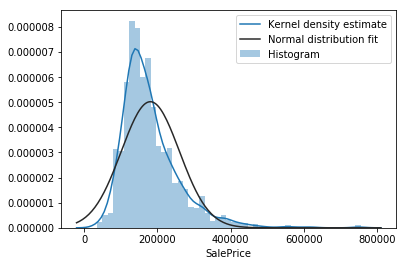

In [10]:
# Distribution of the target varaible
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )

plt.legend()
# observe the transformed distribution


NormaltestResult(statistic=25.507009834238303, pvalue=2.89216582205235e-06)


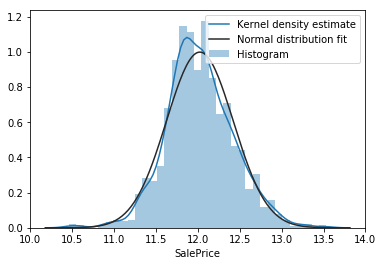

In [11]:
sns.distplot(np.log(df.SalePrice), 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()
train.SalePrice = np.log(train.SalePrice)
print(stats.normaltest(np.log(df.SalePrice)))

In [12]:
linreg(train, test)

Linear regression root mean squared log test error: 0.11543821652710677
Linear regression root mean squared log train error: 0.006809794613663609


In [13]:
# It is the first feature to delete. No information.
columns_to_remove = ['Id']
# Find features with low variance - we assume that they cannot help to infer the observable
# this makes sense especially for indicators
columns_to_remove = list(set(list(train.columns[train.var() < 0.00001]) + columns_to_remove)) 


In [14]:
train = train.drop(columns_to_remove, axis=1, errors = 'ignore')
test = test.drop(columns_to_remove, axis=1, errors = 'ignore')

In [15]:
linreg(train, test)

Linear regression root mean squared log test error: 0.11532958221289899
Linear regression root mean squared log train error: 0.006816762704484568


In [16]:
# Correlation matrix Pearson & Spearman
corrP = train.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')

In [17]:
# Pearson top 10 with target
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])

SalePrice        1.000000
OverallQual      0.815952
SqrtTotalSF      0.802140
TotalSF          0.766802
SqrtGrLivArea    0.720137
GrLivArea        0.697059
GarageCars       0.672168
GarageArea       0.636227
TotalBsmtSF      0.605597
Sqrt1stFlrSF     0.605439
Name: SalePrice, dtype: float64

In [18]:
print(train.shape)

(1095, 312)


In [19]:
# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.001].index)
print(additional_columns)
# extend columns_to_remove.
columns_to_remove = list(set(columns_to_remove + additional_columns))

[]


In [20]:
# Remove columns.
train = train.drop(columns_to_remove, axis=1, errors = 'ignore')
test = test.drop(columns_to_remove, axis=1, errors = 'ignore')

In [21]:
# Check.
linreg(train, test)

Linear regression root mean squared log test error: 0.11532958221289899
Linear regression root mean squared log train error: 0.006816762704484568


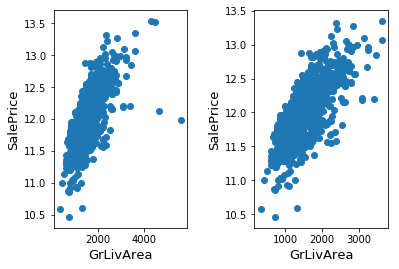

In [22]:
# Vizualization of one feature with target variable.
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('GrLivArea', fontsize=13)

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
ax2.scatter(train['GrLivArea'], train['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('GrLivArea', fontsize=13)
plt.show()


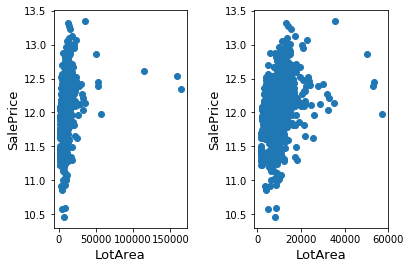

In [23]:
# Vizualization of one feature with target variable.
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(x = train['LotArea'], y = train['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('LotArea', fontsize=13)

#Deleting outliers
train = train.drop(train[(train['LotArea']>100000)].index)

#Check the graphic again
ax2.scatter(train['LotArea'], train['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('LotArea', fontsize=13)
plt.show()

/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Linear regression root mean squared log test error: 0.11427555798694218
Linear regression root mean squared log train error: 0.00665550720104708


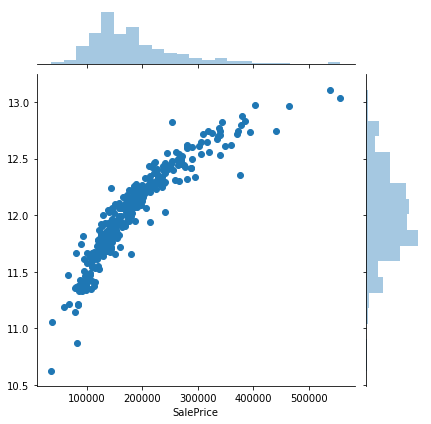

In [24]:
linreg(train, test, True)

In [25]:
# Remove columns which has a lot of same values in hot encoding.
for i in train.columns:
    if np.count_nonzero((train[i] == 1 )) > 900 and len((train[i]).unique())<3:
        # Remove columns.
        train = train.drop(i, axis=1, errors = 'ignore')
        test = test.drop(i, axis=1, errors = 'ignore')

In [26]:
linreg(train, test)

Linear regression root mean squared log test error: 0.11534954616048483
Linear regression root mean squared log train error: 0.0066660076142009105


In [27]:
# The Lasso - L^1 regularized regression to obtain a sparse solution
# Then the non-zero features may be extracted from the result.

# Prepare the data
X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = train.SalePrice

used_columns = X.columns

# We use the base estimator Lasso since the L1 norm promotes sparsity of features.
clf = linear_model.Lasso(alpha = 0, max_iter = 1000)

sfm = feature_selection.SelectFromModel(clf)
sfm.fit(X, y)

# transform result to dataframe
result = pd.DataFrame({'Chosen': sfm.get_support()}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', result.Chosen.sum(),'from ', result.Chosen.shape[0], 'features.')

/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:197: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.estimator_.fit(X, y, **fit_params)
/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Chosen
LotArea,False
RoofMatl_ClyTile,False
PoolQC_Ex,False
SqrtHouseStyle_SFoyer,False


Chosen 285 from  289 features.


/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Linear regression root mean squared log test error: 0.11230839551463907
Linear regression root mean squared log train error: 0.006670884786295166


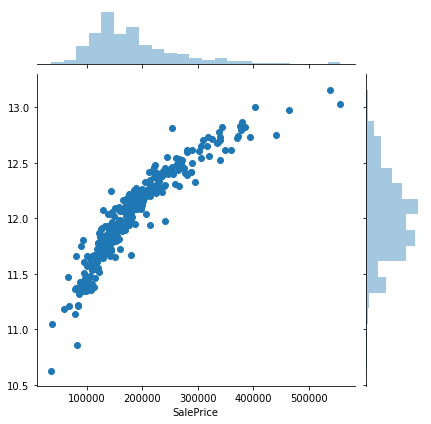

In [28]:
linreg(train[list(columns_to_leave) + ['SalePrice']], test[list(columns_to_leave) + ['SalePrice']], True)

/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Linear regression root mean squared log test error: 0.11230839551463907
Linear regression root mean squared log train error: 0.006670884786295166


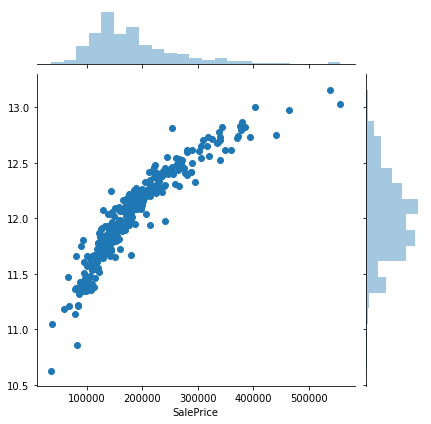

In [29]:
from sklearn.decomposition import PCA
X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = train.SalePrice
pca = PCA(n_components=4)

pd.DataFrame(pca.fit_transform(X))
#print(pca.components_)
#print(pca.explained_variance_ratio_)  
#print(pca.singular_values_) 

# transform result to dataframe
linreg(train[list(columns_to_leave) + ['SalePrice']], test[list(columns_to_leave) + ['SalePrice']], True)